<p align="left">
  <img src="./logo_UTN.svg" />
</p>


# **Teoría de Circuitos II - R4001 - 2023**
## Trabajo Semanal 5
### Autor: Bruno Glecer

# Consigna

La tarea semanal consiste en diseñar un filtro pasa-altos que respete la siguiente plantilla.

<div>
    <img src="plantilla.png" width="400"/>
</div>

Donde los parametros son los siguientes:
- $\large\alpha_{max} = 1\mathrm{dB}$
- $\large\alpha_{min} = 30\mathrm{dB}$
- $\large f_{p} = 40\mathrm{kHz}$
- $\large f_{s} = 10\mathrm{kHz}$

Se piden las siguientes consignas:

1. Obtener la transferencia de máxima planicidad del filtro requerido.
2. Obtener el diagrama de polos y ceros, y un bosquejo de la respuesta en frecuencia. Compare el diagrama de polos y ceros con el del filtro pasabajo prototipo.
3. Implementar el circuito normalizado con estructuras pasivas. (Puede utilizar dispositivos activos para separar secciones).
4. Reemplace los inductores en las estructuras pasivas mediante el GIC de Antoniou, en la configuración que considere más apropiada.
5. Simulación numérica y circuital.



# 1. Transferencia

Comenzamos normalizando el filtro usando $\omega_p$ como norma y utilizamos el nucleo $p = K(s) = \frac{1}{s}$

In [1]:
import numpy as np

#Normalizacion de valores

wp = 40*10**3
ws = 10*10**3
alpha_max = 1
alpha_min = 30

norma_w = wp

wp_n = wp/norma_w
ws_n = ws/norma_w


#Aplicacion del nucleo de transformacion

wp_lp = 1.0/wp_n
ws_lp = 1.0/ws_n

print(f"wp_lp = {wp_lp}    ws_lp = {ws_lp}")

wp_lp = 1.0    ws_lp = 4.0


Continuamos encontrando la función de transferencia del filtro prototipo low-pass.

Al ser un filtro de máxima planicidad, el filtro low pass tendra una función de transferencia de potencia:

$|T_{LP}(\Omega)|^2 = \dfrac{1}{1 + \varepsilon^2 \Omega^{2n}}$

In [2]:
#Calculo de epsilon

epsilon = np.sqrt(10**(alpha_max/10) - 1)

#Calculo de orden

n = 1

while (10*np.log10(1 + epsilon**2 * ws_lp ** (2*n))) < alpha_min:
    n += 1

alpha_ws = 10*np.log10(1 + epsilon**2 * ws_lp ** (2*n))

    
print(f"epsilon = {epsilon}    n = {n}   alpha_ws = {alpha_ws}")

epsilon = 0.5088471399095875    n = 3   alpha_ws = 30.259439266746135


Seguimos buscando las raices de la funcion de transferencia de potencia de este prototipo y separando los polos que esten en el semiplano compljeo izquierdo ($\Sigma < 0$)

In [3]:
den_tlp2 = np.zeros(2*n+1)
den_tlp2[0] = 1
den_tlp2[-1] = -epsilon**2


polos_tlp2 = np.roots(den_tlp2)

polos_tlp = polos_tlp2[np.real(polos_tlp2) < 0]

print(f"Polos de transferencia: {polos_tlp}")

Polos de transferencia: [-0.7983545 +0.j         -0.39917725+0.69139528j -0.39917725-0.69139528j]


Utilizando estos polos, que consisten de dos polos conjugados y un polo en el eje real, puedo construir mi funcion de transferencia del prototipo para que cumpla $|T_{LP}(p)|^2 = T_{LP}(p) \cdot T_{LP}(-p)$ 

In [4]:
from scipy import signal
from pytc2.sistemas_lineales import analyze_sys, pretty_print_bicuad_omegayq,tfcascade,pretty_print_lti
from sympy.abc import p, s, T
import sympy
from IPython.display import display
#Calculo transferencia del prototipo

def round_expr(expr, num_digits):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(sympy.Number)})

t_lp_num = [epsilon]
t_lp_den = np.poly(polos_tlp)
t_lp_den /= t_lp_den[0]
t_lp_num /= t_lp_den[0]

print("Transferencia T_LP(p): ")

pretty_print_lti(t_lp_num,t_lp_den)

#Calculo trasnferencia del objetivo

t_lp = sympy.Eq(T, sympy.Poly(t_lp_num, p)/sympy.Poly(t_lp_den, p))

nucleo_p_s = sympy.Eq(p, 1/s) #Nucleo de transformacion

t_hp = sympy.solve([t_lp, nucleo_p_s], [T, p], dict=True)[0][T]

t_hp_num = sympy.fraction(t_hp, s)[0]
t_hp_den = sympy.fraction(t_hp, s)[1]

t_hp_num = t_hp_num.as_poly(domain='C').as_expr()
t_hp_den = t_hp_den.as_poly(domain='C').as_expr()

t_hp_num /= t_hp_den.coeff(s,n)
t_hp_den /= t_hp_den.coeff(s,n)

t_hp = t_hp_num/t_hp_den

print("Transferencia T_HP(s):")

display(round_expr(t_hp,3))

Transferencia T_LP(p): 


<IPython.core.display.Math object>

Transferencia T_HP(s):


1.0*s**3/(1.0*s**3 + 2.505*s**2 + 3.138*s + 1.965)

A continuacion verifico el resultado anterior utilizando la libreria scipy y la libreria pytc2.

In [5]:
from pytc2.sistemas_lineales import analyze_sys, pretty_print_bicuad_omegayq,tfcascade,pretty_print_lti

w_butter = epsilon**(1/n)
t_lp_num_scipy, t_lp_den_scipy = signal.butter(n, 1*w_butter, btype='lowpass', analog=True)
t_hp_num_scipy, t_hp_den_scipy = signal.butter(n, 1*(1/w_butter), btype='highpass', analog=True)
 
t_hp_scipy = signal.TransferFunction( t_hp_num_scipy, t_hp_den_scipy )
t_lp_scipy = signal.TransferFunction( t_lp_num_scipy, t_lp_den_scipy )

print("Transferencia T_LP(p): ")
pretty_print_lti(t_lp_scipy)

print("Transferencia T_HP(s):")
pretty_print_lti(t_hp_scipy)


Transferencia T_LP(p): 


<IPython.core.display.Math object>

Transferencia T_HP(s):


<IPython.core.display.Math object>

Esto concluye el desarrollo de la función de transferencia del filtro pasa altos requerido.

# 2. Diagramas de polos y ceros

## Filtro objetivo (normalizado)

Utilizamos la libreria pytc2 para los diagramas de bode y polos y ceros.

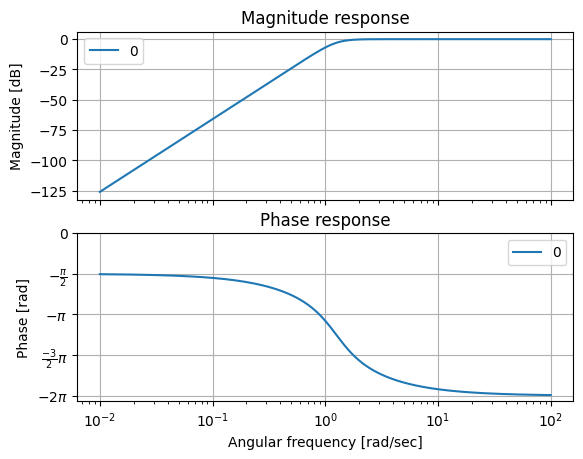

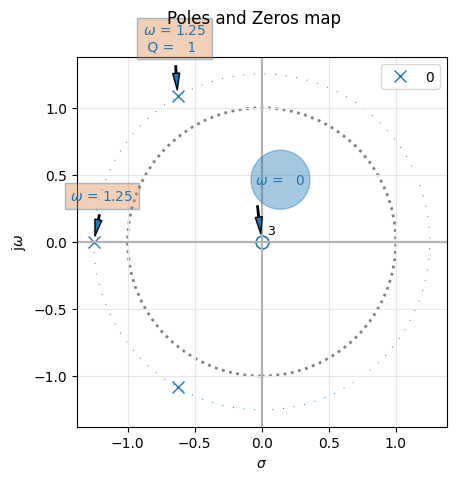

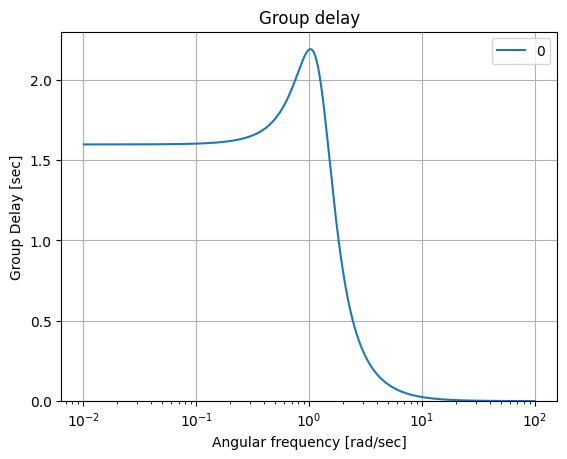

In [6]:
analyze_sys(t_hp_scipy)

## Filtro prototipo (normalizado)

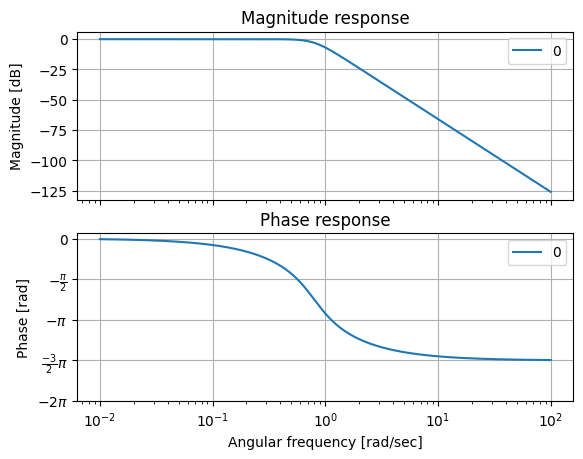

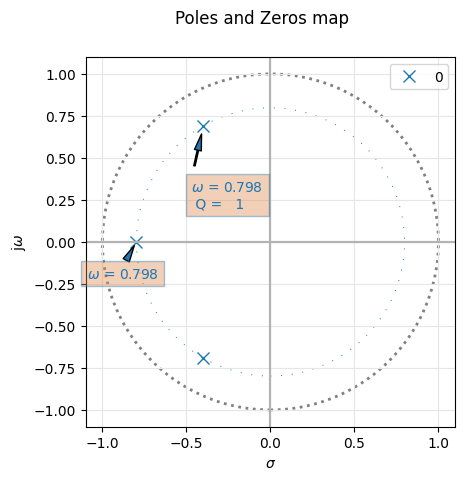

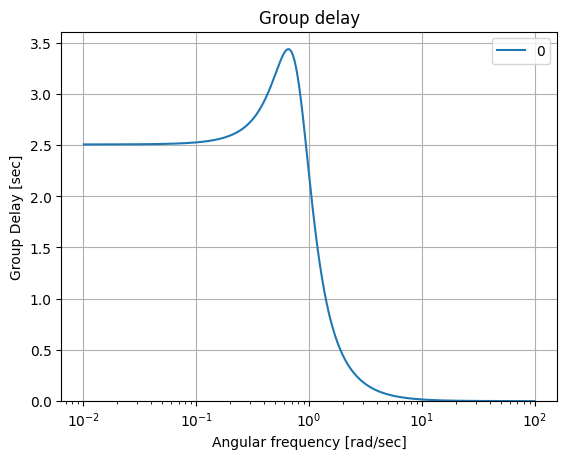

In [7]:
analyze_sys(t_lp_scipy)

Por simple inspeccion se puede observar como la transformacion entre el prototipo pasa bajos y el objetivo pasa altos cambia el $\omega_0$ de los polos, pasan del interior de la circunferencia unitaria a el exterior. Tambien se observa como nacen 3 ceros en el origen de la transferencia del filtro objetivo. La respuesta en frecuencia es la esperada, se puede ver su comportamiento de maxima planicidad, y su retardo de grupo caracteristico de los filtros de maxima planicidad.

# 3. Implementación Pasiva


Primero comenzamos separando la transferencia en etapas de orden 1 o 2.

In [8]:
import warnings
warnings.simplefilter("ignore", signal.BadCoefficients)

t_hp_sos = signal.tf2sos(t_hp_num_scipy, t_hp_den_scipy, analog=True)

sections = [signal.TransferFunction(x[:3], x[3:]) for x in t_hp_sos]

omega_0 = []
q = []

n_etapas = len(sections)
orden_etapa = [len(t_section.den) for t_section in sections]

for etapa in range(n_etapas):
    if orden_etapa[etapa] == 2: #Etapa de primer orden
        omega_0 += [sections[etapa].den[1]]
        q += [0]
    if orden_etapa[etapa] == 3: #Etapa de segundo orden
        omega_0 += [np.sqrt(sections[etapa].den[2])]
        q += [np.sqrt(sections[etapa].den[2])/sections[etapa].den[1]]
        
    pretty_print_lti(sections[etapa])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Como es de esperar de un filtro de orden 3, se puede descomponer en una etapa de primer orden y otra de segundo, ambas pasa altos. Para realizar el circuito utilizaremos las siguientes topologias, con sus respectivas funciones de transferencia.


<div>
    <img src="etapas.png" width="600"/>
</div>

Utilizamos python para el calculo de los valores de los componentes, continuamos manteniendo la normalizacion

In [9]:
#Etapa 1

R1 = 1
C1 = 1*omega_0[0]
print(f"Etapa 1:\n R={R1} \n C={C1} \n\n")

R2 = 1
C2 = 1/q[1]*omega_0[1]
L1 = q[1]*omega_0[1]
print(f"Etapa 2:\n R={R2} \n C={C2} \n L={L1} \n\n")

Etapa 1:
 R=1 
 C=1.2525763881810272 


Etapa 2:
 R=1 
 C=1.252576388181027 
 L=1.252576388181026 




Utilizando estos valores y un seguidor de tension, diseñamos el filtro con componentes pasivos.

<div>
    <img src="pasivo.png" width="600"/>
</div>

Para la construcicon fisica de este circuito es necesario la desnormalizacion en impedancia y frecuencia. La norma original de frecuencia fue $\omega_n = \omega_p = 2\pi ~ 40 \mathrm{kHz}$. La norma de impedancia la llamaremos $Z_n$ y no esta fijada por la consigna.

Para desnormalizar los componentes deben ser ajustados de la siguiente manera:

#### Resistencias
$R = R' Z_n$

#### Capacitores
$C = C' \dfrac{1}{Z_n \omega_n}$

#### Inductores
$L = L' \dfrac{Z_n}{\omega_n}$

Donde $R'$, $C'$ y $L'$ son los valores normalizados representados en el esquematico y $R$, $C$ y $L$ son los valores fisicos a implementar.

# 4. Implementación Activa

El GIC de Antoniou consiste de la siguiente red:

<div>
    <img src="gic.png" width="600"/>
</div>

Con la siguiente impedancia de entrada:

$$Z_{in}(s) = \frac{Z_1 Z_3 Z_5}{Z_2 Z_4}$$


Aprovechamos la propiedad de que si se pone una impedancia imaginaria negativa(capacitiva) en el denominador ($Z_2$ o $Z_4$), la impedancia de entrada $Z_in$ toma un valor imaginario positivo (inductivo). Para lograr esto, elegimos los siguientes valores (normalizados) $Z_1 = Z_2 = Z_3 = Z_5 = Z_{GIC}$ y $Z_4 = /frac{1}{sC}$, resultando en:

$$Z_{in}(s) = C ~ Z_{GIC}^2 ~ s$$

Esta red tiene una impedancia de entrada identica a la de un inductor conectado a masa de una inductancia de $L =C ~ Z_{GIC}^2$

Por simplicidad, en el dominio normalizado tomaremos $Z_{GIC} = 1$. Lo cual nos da un valor $C$ igual al valor normalizado del inductor de la segunda etapa.

<div>
    <img src="activo.png" width="600"/>
</div>

Nuevamente, para la implementacion fisica de este circuito es necesario la desnormalizacion como se explico para la implementacion pasiva.

# 5. Simulacion

Utilizando LTSpice, simulamos ambas sintesis de los filtros. Para implementar el circuito en la simulacion, tomamos $Z_n = 1k\Omega$

## Esquematico de la simulacion

<div>
    <img src="sim_esq.png" width="800"/>
</div>

## Resultados de la simulacion

### Graficos

<div>
    <img src="sim_res.png" width="600"/>
</div>

Arriba se muestran ambos graficos, la respuesta en modulo y fase de la version pasiva y de la version activa. Debido a que son identicos, se encuentras superpuestos.

### Mediciones


>```
>t_ws_pasivo: v(vo1)=(-30.2606dB,-126.533°) at 10000
>t_wp_pasivo: v(vo1)=(-1.00026dB,104.18°) at 40000
>t_ws_activo: v(vo2)=(-30.2601dB,-126.537°) at 10000
>t_wp_activo: v(vo2)=(-1.00029dB,104.174°) at 40000
>```


Las mediciones de ganancia en las frecuencias de paso y corte coinciden con alta exactitud a los valores planteados inicialmente en la plantilla de $T(f_s) = -30.259\mathrm{dB}$ y $T(f_p) = -1\mathrm{dB}$